In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import seaborn as sns
import os
import pickle
import sys
sys.path.append("..")
from tqdm import tqdm
import networkx as nx
from tools.opera_tools import plot_dataframe

In [2]:
import pandas as pd
EPS = 1e-6

## Чтение данных

In [3]:
import pandas as pd
from tqdm import tqdm_notebook

def digraph_to_csv(graphs: list):
    df = pd.DataFrame(columns=['brick_id', 'shower_id', 'SX', 'SY', 'SZ', 'TX', 'TY'])
    for i, graph in tqdm_notebook(enumerate(graphs)):
        nodes = graph.nodes()
        SX = [node['features']['SX'] for node in nodes.values()]
        SY = [node['features']['SY'] for node in nodes.values()]
        SZ = [node['features']['SZ'] for node in nodes.values()]
        TX = [node['features']['TX'] for node in nodes.values()]
        TY = [node['features']['TY'] for node in nodes.values()]
        shower_id = [node['signal'] for node in nodes.values()]
        brick_id = [i for _ in range(len(shower_id))]
        df = df.append(
            pd.DataFrame(
                {'brick_id': brick_id, 
                 'shower_id': shower_id, 
                 'SX': SX, 
                 'SY': SY, 
                 'SZ': SZ, 
                 'TX': TX, 
                 'TY': TY
                }
            )
        )
    return df
        

def csv_to_digraph(df: pd.DataFrame):
    bricks = []
    for name, group in df.groupby('brick_id'):
        print(group.shape)
        nodes_to_add = []

        for node_id, row in group.iterrows():
            nodes_to_add.append(
                (
                    node_id,
                    {
                        'features': {
                            'SX': row.SX,
                            'SY': row.SY,
                            'SZ': row.SZ,
                            'TX': row.TX,
                            'TY': row.TY,
                        },
                        'signal': row['shower_id']
                    }
                )
            )
        graphx = nx.DiGraph()
        graphx.add_nodes_from(nodes_to_add)
        bricks.append(graphx)
    return bricks

In [4]:
df = pd.read_csv('./opera_train.csv')

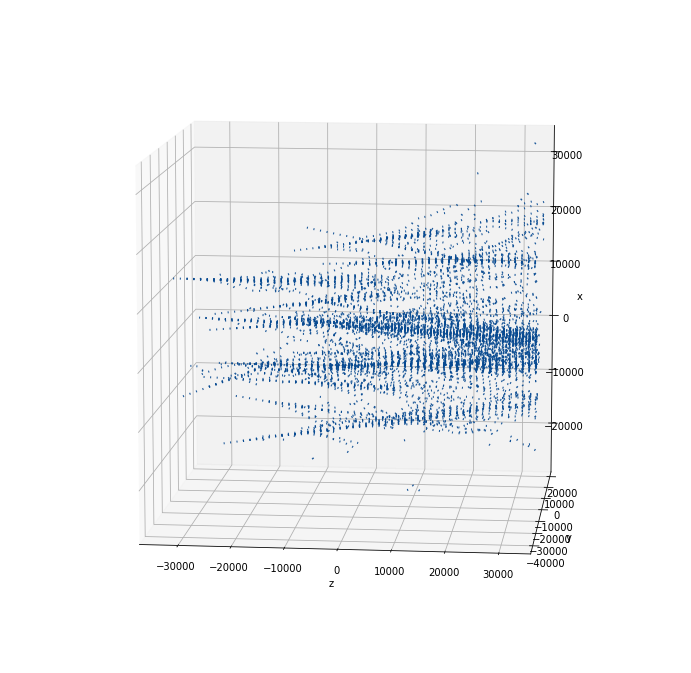

In [9]:
# будьте осторжны! Не подавайте на вход весь датафрейм
plot_dataframe(df.loc[df.brick_id==0])

In [ ]:
from sklearn.metrics import fowlkes_mallows_score
def scorer(labels_true, labels_pred):
    groups, labels_true = labels_true.T
    _, labels_pred = labels_pred.T
    if groups is None:
        return fowlkes_mallows_score(labels_true=labels_true, labels_pred=labels_pred)
    fowlkes_mallows = 0.
    for group in np.unique(groups):
        fowlkes_mallows += fowlkes_mallows_score(labels_true=labels_true[groups==group], 
                                                 labels_pred=labels_pred[groups==group])
    return fowlkes_mallows / len(np.unique(groups))

In [11]:
from sklearn.cluster import DBSCAN

/mnt/vbelavin/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
predicted_labels = []

In [26]:
from tqdm import tqdm_notebook
for name, group in tqdm_notebook(df.groupby('brick_id')):
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(group[['SX', 'SY', 'SZ', 'TX', 'TY']].values / np.array([1e4, 1e4, 1e4, 1., 1.]))
    predicted_labels.append(pred)

In [30]:
scorer(df.shower_id.values, np.concatenate(predicted_labels), groups=df.brick_id.values)

0.2874403094775477

In [31]:
df = pd.read_csv('./opera_test.csv')

In [32]:
from tqdm import tqdm_notebook
for name, group in tqdm_notebook(df.groupby('brick_id')):
    dbscan = DBSCAN()
    pred = dbscan.fit_predict(group[['SX', 'SY', 'SZ', 'TX', 'TY']].values / np.array([1e4, 1e4, 1e4, 1., 1.]))
    predicted_labels.append(pred)

In [35]:
np.savetxt('answers.csv', np.concatenate(predicted_labels), delimiter='\n')